In [374]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio
import pims
from skimage.measure import label, regionprops
from skimage.color import label2rgb
import scipy

import warnings
warnings.filterwarnings('ignore')

In [375]:
expdir='/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed culture/Leica confocal/'
protein="TNR" #TNR,Agg,WFA,HABP

In [376]:
results = {"filename":[],
          "exp condition":[],
          "ecmchannelno":[],
          "endosomechannelno":[],
           "Manual ECM spots mask":[],
           "Manual endosome spots mask":[],
          }
           
path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    if "_analyse" in str(filelist[i]):
        if "2019" in str(filelist[i]):
            if ("posthoc" in str(filelist[i]))==False:
                #if (protein in str(filelist[i]))==True:
                    if filelist[i].endswith(".tif"): 
                        if str(filelist[i][:-12]) not in str(results["filename"]):
                            results["filename"].append(filelist[i][:-12])
                            results["exp condition"].append(filelist[i][:-12].split('/')[-2])
                            channeldir="/".join(filelist[i][:-12].split("/")[:-1])
                            exec(open(channeldir+"/channels.txt").read())
                            results["ecmchannelno"].append(ecmchannelno)
                            results["endosomechannelno"].append(endosomechannelno)
                                        

## Loading a random image

ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: 20190627_positivecontrol_tnr_secondarystar580_star635P_Series24_z
Experimental condition: 20190627_positivecontrol_tnr_secondarystar580_star635P


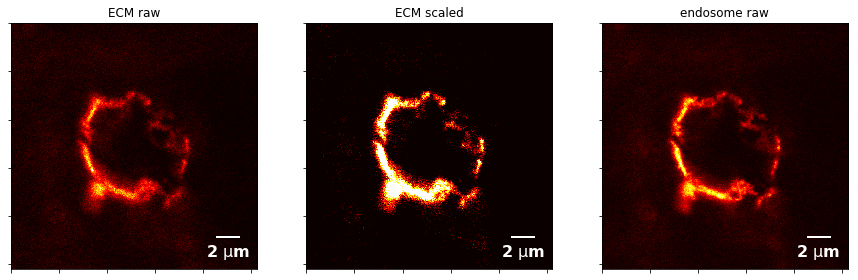

In [377]:
randomno=np.random.randint(1,len(results["filename"]))
ecm_channel_no=results["ecmchannelno"][randomno]
endosome_channel_no=results["endosomechannelno"][randomno]

ecm_image_name=results["filename"][randomno]+"0_ch"+str(ecm_channel_no-1)+"_t0.tif"
endosome_image_name=results["filename"][randomno]+"0_ch"+str(endosome_channel_no-1)+"_t0.tif"

print("Image name:",results["filename"][randomno].split('/')[-1])
print("Experimental condition:",results["exp condition"][randomno])
ecm_image=pims.open(ecm_image_name)[0]
endosome_image=pims.open(endosome_image_name)[0]
   
figure=plt.figure(figsize=(15,15))
figure.add_subplot(131)
plt.imshow(ecm_image,interpolation='none',cmap='hot')
plt.title('ECM raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(40, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)
figure.add_subplot(132)
plt.imshow(ecm_image,interpolation='none',cmap='hot',vmin=3*np.min(ecm_image),vmax=0.4*np.max(ecm_image))
plt.title('ECM scaled')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(40, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    
plt.gca().add_artist(scalebar)

figure.add_subplot(133)
plt.imshow(endosome_image,interpolation='none',cmap='hot')
plt.title('endosome raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(40, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    
plt.gca().add_artist(scalebar)

## Load manual spots

In [378]:
for image in range(0,len(results["filename"])):
    results["Manual ECM spots mask"].append(np.load(results["filename"][image]+'_ecm_spots_mask.npy'))
    results["Manual endosome spots mask"].append(np.load(results["filename"][image]+'_endosome_spots_mask.npy'))

### Sanity check

ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Min distance for real image = 0.0
Min distance for rotated image = 0.0
Min percent under 50nm for real image = 4.761904761904762
Min percent under 50nm for rotated image = 4.761904761904762


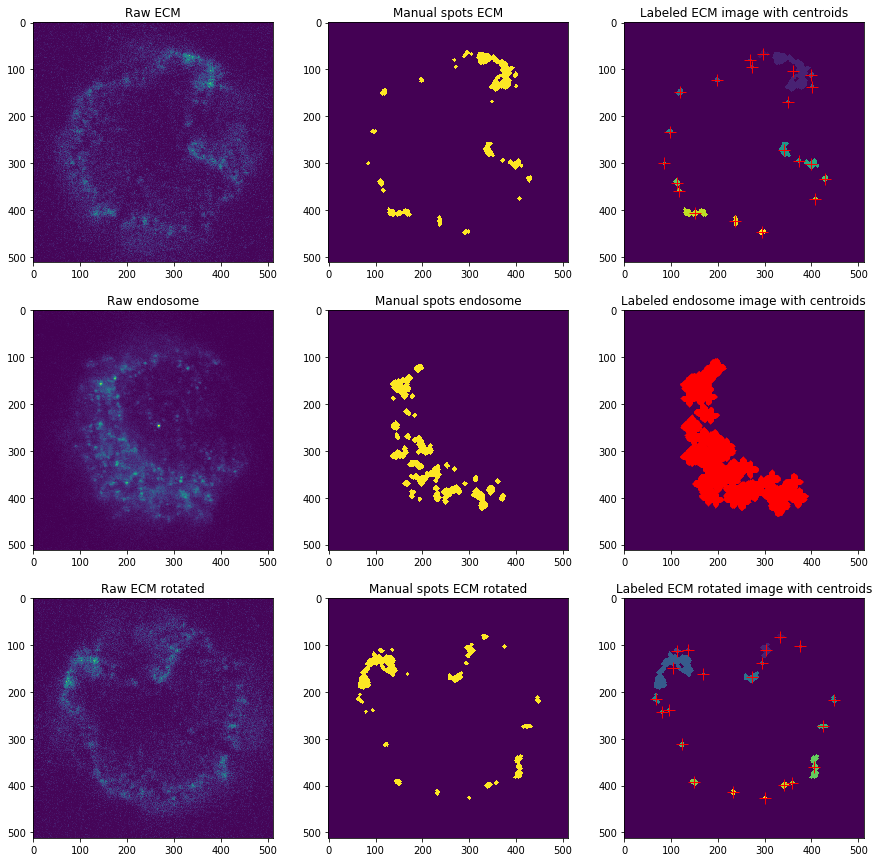

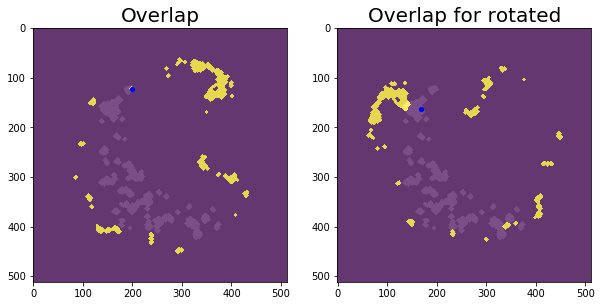

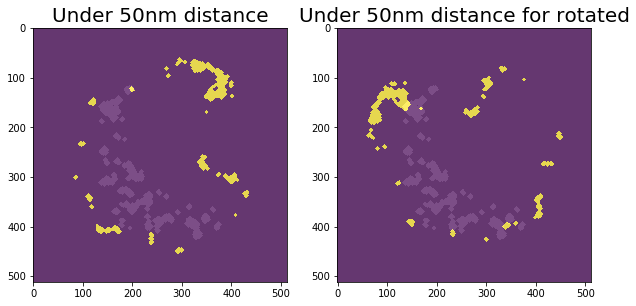

In [10]:
randomno=np.random.randint(1,len(results["filename"]))
ecm_channel_no=results["ecmchannelno"][randomno]
endosome_channel_no=results["endosomechannelno"][randomno]

ecm_image_name=results["filename"][randomno]+"0_ch"+str(ecm_channel_no-1)+"_t0.tif"
endosome_image_name=results["filename"][randomno]+"0_ch"+str(endosome_channel_no-1)+"_t0.tif"

ecm_image=pims.open(ecm_image_name)[0]
endosome_image=pims.open(endosome_image_name)[0]

#read spots masks and label
ecm_mask=results["Manual ECM spots mask"][randomno]
endosome_mask=results["Manual endosome spots mask"][randomno]
#rotated ecm mask
rot_ecm_mask=deepcopy(ecm_mask)
rot_ecm_mask=np.rot90(rot_ecm_mask)
labeled_ecm=label(ecm_mask)
rot_labeled_ecm=label(rot_ecm_mask)
labeled_endosome=label(endosome_mask)

regionprops_ecm=regionprops(labeled_ecm)
regionprops_endosome=regionprops(labeled_endosome)
rot_regionprops_ecm=regionprops(rot_labeled_ecm)

ecm_spots_results_sanity=[]
rot_ecm_spots_results_sanity=[]
endosome_spots_results_sanity=[]
for i in range(0,len(regionprops_ecm)):
    ecm_spots_results_sanity.append(regionprops_ecm[i]['centroid'])
for i in range(0,len(rot_regionprops_ecm)):
    rot_ecm_spots_results_sanity.append(rot_regionprops_ecm[i]['centroid'])
for i in range(0,len(regionprops_endosome)):
    endosome_spots_results_sanity.append(regionprops_endosome[i]['coords'])

#minimum distance between spots
distances=[]
rot_distances=[]
for blob in range(0,len(endosome_spots_results_sanity)):
    distances.append(scipy.spatial.distance.cdist
                     (np.round(ecm_spots_results_sanity),endosome_spots_results_sanity[blob],'euclidean'))
    
    rot_distances.append(scipy.spatial.distance.cdist
                     (np.round(rot_ecm_spots_results_sanity),endosome_spots_results_sanity[blob],'euclidean'))
    
#make array of min distance from each ecm centroid
ecm_min_distances_array=np.amin(distances[0],1,keepdims=True)
for blob in range(1,len(endosome_spots_results_sanity)):
    newmins=np.amin(distances[blob],1,keepdims=True)
    concat=np.concatenate([deepcopy(ecm_min_distances_array),newmins],1)
    ecm_min_distances_array=np.amin(deepcopy(concat),1,keepdims=True)
rot_ecm_min_distances_array=np.amin(rot_distances[0],1,keepdims=True)
for blob in range(1,len(endosome_spots_results_sanity)):
    newmins=np.amin(rot_distances[blob],1,keepdims=True)
    concat=np.concatenate([deepcopy(rot_ecm_min_distances_array),newmins],1)
    rot_ecm_min_distances_array=np.amin(deepcopy(concat),1,keepdims=True)
    

#find the coordinates of the closest ecm centroid and endosome boundary
endosomeblobcount=-1
for i in range(0,len(distances)):
    endosomeblobcount+=1
    l= np.where(distances[i]==np.min(ecm_min_distances_array))
    if l[1].size:
        endosomeblob_ecmcentroid_endosomecoords=[endosomeblobcount,l[0][0],l[1][0]]

closest_ecm_coords=ecm_spots_results_sanity[endosomeblob_ecmcentroid_endosomecoords[1]]
closest_endosome_boundary_coords=endosome_spots_results_sanity[endosomeblob_ecmcentroid_endosomecoords[0]][endosomeblob_ecmcentroid_endosomecoords[2]]

endosomeblobcount=-1
for i in range(0,len(rot_distances)):
    endosomeblobcount+=1
    l= np.where(rot_distances[i]==np.min(rot_ecm_min_distances_array))
    if l[1].size:
        rot_endosomeblob_ecmcentroid_endosomecoords=[endosomeblobcount,l[0][0],l[1][0]]

rot_closest_ecm_coords=rot_ecm_spots_results_sanity[rot_endosomeblob_ecmcentroid_endosomecoords[1]]
rot_closest_endosome_boundary_coords=endosome_spots_results_sanity[rot_endosomeblob_ecmcentroid_endosomecoords[0]][rot_endosomeblob_ecmcentroid_endosomecoords[2]]


print('Min distance for real image = '+str(np.min(ecm_min_distances_array)))
print('Min distance for rotated image = '+str(np.min(rot_ecm_min_distances_array)))
    
fig=plt.figure(figsize=(15,15))
fig.add_subplot(331)
plt.title('Raw ECM')
plt.imshow(ecm_image)
fig.add_subplot(332)
plt.title('Manual spots ECM')
plt.imshow(ecm_mask)
fig.add_subplot(333)
plt.title('Labeled ECM image with centroids')
plt.imshow(labeled_ecm)
for i in range(0,len(ecm_spots_results_sanity)):
    plt.plot(ecm_spots_results_sanity[i][1],ecm_spots_results_sanity[i][0],'+',color='r',markersize=12)

fig.add_subplot(334)
plt.title('Raw endosome')
plt.imshow(endosome_image)
fig.add_subplot(335)
plt.title('Manual spots endosome')
plt.imshow(endosome_mask)
fig.add_subplot(336)
plt.title('Labeled endosome image with centroids')
plt.imshow(labeled_endosome)
for i in range(0,len(endosome_spots_results_sanity)):
    for j in range(0,len(endosome_spots_results_sanity[i])):
        plt.plot(endosome_spots_results_sanity[i][j][1],endosome_spots_results_sanity[i][j][0],'+',color='r',markersize=12)

fig.add_subplot(337)
plt.title('Raw ECM rotated')
plt.imshow(np.rot90(ecm_image))
fig.add_subplot(338)
plt.title('Manual spots ECM rotated')
plt.imshow(rot_ecm_mask)
fig.add_subplot(339)
plt.title('Labeled ECM rotated image with centroids')
plt.imshow(rot_labeled_ecm)
for i in range(0,len(ecm_spots_results_sanity)):
    plt.plot(rot_ecm_spots_results_sanity[i][1],rot_ecm_spots_results_sanity[i][0],'+',color='r',markersize=12)

newfig=plt.figure(figsize=(10,10))
newfig.add_subplot(121)
plt.title('Overlap', size=20)
plt.imshow(endosome_mask,cmap='gray',alpha=0.3)
plt.imshow(ecm_mask,cmap='viridis',alpha=0.7)
plt.plot(closest_ecm_coords[1],closest_ecm_coords[0],'o',markersize=4,color='g')
plt.plot(closest_endosome_boundary_coords[1],closest_endosome_boundary_coords[0],'o',markersize=4,color='b')

newfig.add_subplot(122)
plt.title('Overlap for rotated', size=20)
plt.imshow(endosome_mask,cmap='gray',alpha=0.3)
plt.imshow(rot_ecm_mask,cmap='viridis',alpha=0.7)
plt.plot(rot_closest_ecm_coords[1],rot_closest_ecm_coords[0],'o',markersize=4,color='g')
plt.plot(rot_closest_endosome_boundary_coords[1],rot_closest_endosome_boundary_coords[0],'o',markersize=4,color='b')

##show percent of under 50nm (=1.24pxls)

percent_under=sum(np.array(ecm_min_distances_array)<1.24)/len(ecm_min_distances_array)*100
percent_under_rot=sum(np.array(rot_ecm_min_distances_array)<1.24)/len(rot_ecm_min_distances_array)*100

print('Min percent under 50nm for real image = '+str(percent_under[0]))
print('Min percent under 50nm for rotated image = '+str(percent_under_rot[0]))

fig=plt.figure(figsize=(10,10))
fig.add_subplot(121)
plt.title('Under 50nm distance', size=20)
plt.imshow(endosome_mask,cmap='gray',alpha=0.3)
plt.imshow(ecm_mask,cmap='viridis',alpha=0.7)
c=np.where(np.array(ecm_min_distances_array)<1.24)
if len(c[0])>0:
    for min in range(0,len(c[0])-1):
        plt.plot(ecm_spots_results_sanity[c[0][min]][1],ecm_spots_results_sanity[c[0][min]][0],'o',color='green',markersize=20)


fig.add_subplot(122)
plt.title('Under 50nm distance for rotated', size=20)
plt.imshow(endosome_mask,cmap='gray',alpha=0.3)
plt.imshow(rot_ecm_mask,cmap='viridis',alpha=0.7)
c=np.where(np.array(rot_ecm_min_distances_array)<1.24)
if len(c[0])>0:
    for min in range(0,len(c[0])-1):
        plt.plot(rot_ecm_spots_results_sanity[c[0][min]][1],rot_ecm_spots_results_sanity[c[0][min]][0],'o',color='green',markersize=20)




## Batch analysis on spots

### Dictionary of spot regionprops

In [379]:
#dictionary per image:
ecm_image_results={"filename":[],"exp condition":[],
                   "distances to nearest endosome boundary":[],
                  "distances to nearest endosome boundary [nms]":[],
                  "min distance to nearest endosome boundary for whole image":[],
                  "min distance to nearest endosome boundary for whole image [nms]":[],
                  "rotated - distances to nearest endosome boundary":[],
                  "rotated - distances to nearest endosome boundary [nms]":[],
                  "rotated - min distance to nearest endosome boundary for whole image":[],
                  "rotated - min distance to nearest endosome boundary for whole image [nms]":[]}

for image in range(0,len(results["filename"])):
    print('Calculating image no ' + str(image+1) + ' out of' + str(len(results["filename"])))
    #read images
    #ecm_channel_no=results["ecmchannelno"][image]
    #endosome_channel_no=results["endosomechannelno"][image]
    #ecm_image_name=results["filename"][image]+"0_ch"+str(ecm_channel_no-1)+"_t0.tif"
    #endosome_image_name=results["filename"][image]+"0_ch"+str(endosome_channel_no-1)+"_t0.tif"
    #ecm_image=pims.open(ecm_image_name)[0]
    #endosome_image=pims.open(endosome_image_name)[0]
    
    #read spots masks and label
    ecm_mask=results["Manual ECM spots mask"][image]
    if len(ecm_mask.shape)==0:
        ecm_mask=np.zeros(ecm_image.shape).astype(bool)
    endosome_mask=results["Manual endosome spots mask"][image]
    if len(endosome_mask.shape)==0:
        endosome_mask=np.zeros(endosome_image.shape).astype(bool)
    #rotated ecm mask
    rot_ecm_mask=deepcopy(ecm_mask)
    rot_ecm_mask=np.flip(rot_ecm_mask)#np.rot90(rot_ecm_mask)
    labeled_ecm=label(ecm_mask)
    rot_labeled_ecm=label(rot_ecm_mask)
    labeled_endosome=label(endosome_mask)
    #regionprops for labeled masks
    if np.sum(ecm_mask>0) & np.sum(endosome_mask>0):
        regionprops_ecm=regionprops(labeled_ecm)
        regionprops_endosome=regionprops(labeled_endosome)
        rot_regionprops_ecm=regionprops(rot_labeled_ecm) 
        ecm_spots_results=[]
        rot_ecm_spots_results=[]
        endosome_spots_results=[]
        for i in range(0,len(regionprops_ecm)):
            ecm_spots_results.append(regionprops_ecm[i]['centroid'])
        for i in range(0,len(rot_regionprops_ecm)):
            rot_ecm_spots_results.append(rot_regionprops_ecm[i]['centroid'])
        for i in range(0,len(regionprops_endosome)):
            endosome_spots_results.append(regionprops_endosome[i]['coords'])
        #minimum distance between spots
        distances=[]
        rot_distances=[]
        for blob in range(0,len(endosome_spots_results)):
            distances.append(scipy.spatial.distance.cdist
                             (np.round(ecm_spots_results),endosome_spots_results[blob],'euclidean'))
            rot_distances.append(scipy.spatial.distance.cdist
                             (np.round(rot_ecm_spots_results),endosome_spots_results[blob],'euclidean'))
        #make array of min distance from each ecm centroid
        ecm_min_distances_array=np.amin(distances[0],1,keepdims=True)
        for blob in range(1,len(endosome_spots_results)):
            newmins=np.amin(distances[blob],1,keepdims=True)
            concat=np.concatenate([deepcopy(ecm_min_distances_array),newmins],1)
            ecm_min_distances_array=np.amin(deepcopy(concat),1,keepdims=True)
        rot_ecm_min_distances_array=np.amin(rot_distances[0],1,keepdims=True)
        for blob in range(1,len(endosome_spots_results)):
            newmins=np.amin(rot_distances[blob],1,keepdims=True)
            concat=np.concatenate([deepcopy(rot_ecm_min_distances_array),newmins],1)
            rot_ecm_min_distances_array=np.amin(deepcopy(concat),1,keepdims=True)

        ecm_image_results["filename"].append(results["filename"][image])
        ecm_image_results["exp condition"].append(results["exp condition"][image])
        ecm_image_results["distances to nearest endosome boundary"].append(ecm_min_distances_array)
        ecm_image_results["rotated - distances to nearest endosome boundary"].append(rot_ecm_min_distances_array)
        ecm_image_results["distances to nearest endosome boundary [nms]"].append(ecm_min_distances_array*40.4)
        ecm_image_results["rotated - distances to nearest endosome boundary [nms]"].append(rot_ecm_min_distances_array*40.4)
        ecm_image_results["min distance to nearest endosome boundary for whole image"].append(np.min(ecm_min_distances_array))
        ecm_image_results["min distance to nearest endosome boundary for whole image [nms]"].append(np.min(ecm_min_distances_array)*40.4)
        ecm_image_results["rotated - min distance to nearest endosome boundary for whole image"].append(np.min(rot_ecm_min_distances_array))
        ecm_image_results["rotated - min distance to nearest endosome boundary for whole image [nms]"].append(np.min(rot_ecm_min_distances_array)*40.4)

Calculating image no 1 out of278
Calculating image no 2 out of278
Calculating image no 3 out of278
Calculating image no 4 out of278
Calculating image no 5 out of278
Calculating image no 6 out of278
Calculating image no 7 out of278
Calculating image no 8 out of278
Calculating image no 9 out of278
Calculating image no 10 out of278
Calculating image no 11 out of278
Calculating image no 12 out of278
Calculating image no 13 out of278
Calculating image no 14 out of278
Calculating image no 15 out of278
Calculating image no 16 out of278
Calculating image no 17 out of278
Calculating image no 18 out of278
Calculating image no 19 out of278
Calculating image no 20 out of278
Calculating image no 21 out of278
Calculating image no 22 out of278
Calculating image no 23 out of278
Calculating image no 24 out of278
Calculating image no 25 out of278
Calculating image no 26 out of278
Calculating image no 27 out of278
Calculating image no 28 out of278
Calculating image no 29 out of278
Calculating image no 30

Calculating image no 244 out of278
Calculating image no 245 out of278
Calculating image no 246 out of278
Calculating image no 247 out of278
Calculating image no 248 out of278
Calculating image no 249 out of278
Calculating image no 250 out of278
Calculating image no 251 out of278
Calculating image no 252 out of278
Calculating image no 253 out of278
Calculating image no 254 out of278
Calculating image no 255 out of278
Calculating image no 256 out of278
Calculating image no 257 out of278
Calculating image no 258 out of278
Calculating image no 259 out of278
Calculating image no 260 out of278
Calculating image no 261 out of278
Calculating image no 262 out of278
Calculating image no 263 out of278
Calculating image no 264 out of278
Calculating image no 265 out of278
Calculating image no 266 out of278
Calculating image no 267 out of278
Calculating image no 268 out of278
Calculating image no 269 out of278
Calculating image no 270 out of278
Calculating image no 271 out of278
Calculating image no

## Plots

In [380]:
df_ecm=pd.DataFrame(ecm_image_results)

## Quick look at distances

(0, 500)

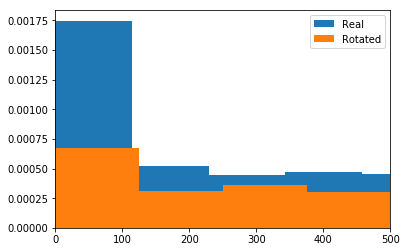

In [13]:
all_distances=[]
for i in range(0,len(df_ecm)):
    all_distances.append(df_ecm["distances to nearest endosome boundary [nms]"][i])
flat_list = []
for sublist in all_distances:
    for item in sublist:
        flat_list.append(item)
all_distances=np.array(flat_list)

all_distances_rot=[]
for i in range(0,len(df_ecm)):
    all_distances_rot.append(df_ecm["rotated - distances to nearest endosome boundary [nms]"][i])
flat_list = []
for sublist in all_distances_rot:
    for item in sublist:
        flat_list.append(item)
all_distances_rot=np.array(flat_list)

plt.figure()
plt.hist(all_distances,density=True,bins=200)
plt.hist(all_distances_rot,density=True,bins=200)
plt.legend(['Real','Rotated'])
plt.xlim([0,500])

## Add protein labels to df

In [381]:
df_ecm['Protein']='None'
df_ecm.loc[(df_ecm['exp condition'].str.contains('nt'))&(df_ecm['exp condition'].str.contains('12')), 'Protein'] = 'Int1b, all TNR Blk+12, stripped'
df_ecm.loc[(df_ecm['exp condition'].str.contains('nt'))&(df_ecm['exp condition'].str.contains('surface')), 'Protein'] = 'Int1b Blk/TNR Blk, +0, surface'
df_ecm.loc[df_ecm['exp condition'].str.contains('tgn'), 'Protein'] = 'TGN38/ TNR Blk, +12'
df_ecm.loc[df_ecm['exp condition'].str.contains('rab11'), 'Protein'] = 'Rab11a/ TNR Blk, +12'
df_ecm.loc[df_ecm['exp condition'].str.contains('cav'), 'Protein'] = 'Cav1/ TNR Blk'
df_ecm.loc[df_ecm['exp condition'].str.contains('negctrl'), 'Protein'] = 'Neg ctrl vAchT'
df_ecm.loc[df_ecm['exp condition'].str.contains('positivecontrol'), 'Protein'] = 'Pos ctrl 2 secondaries'
df_ecm.loc[df_ecm['exp condition'].str.contains('rab7'), 'Protein'] = 'Rab7/ TNR Blk, +12'
df_ecm.loc[df_ecm['exp condition'].str.contains('rab5'), 'Protein'] = 'Rab5/ TNR Blk, +12'
df_ecm.loc[df_ecm['exp condition'].str.contains('lamp'), 'Protein'] = 'lamp1/ TNR Blk, +12'

## Dictionary of spots

In [382]:
spots_list={"filename":[],"expname":[],"Protein":[],"distance to nearest endosome boundary [nms]":[],
            "rotated - distance to nearest endosome boundary [nms]":[]}

for i in range(0,len(df_ecm)):
    nospots=len(df_ecm["distances to nearest endosome boundary [nms]"][i])
    protein=df_ecm["Protein"][i]
    file=df_ecm["filename"][i]
    exp=df_ecm["exp condition"][i]
    for spot in range(0,nospots):
        spots_list["filename"].append(file)
        spots_list["expname"].append(exp)
        spots_list["Protein"].append(protein)
        spots_list["distance to nearest endosome boundary [nms]"].append(
            df_ecm["distances to nearest endosome boundary [nms]"][i][spot][0])
        spots_list["rotated - distance to nearest endosome boundary [nms]"].append(
            df_ecm["rotated - distances to nearest endosome boundary [nms]"][i][spot][0])
        
dfspots=pd.DataFrame(spots_list)

## Plot: histograms for all proteins except pos control, same axis

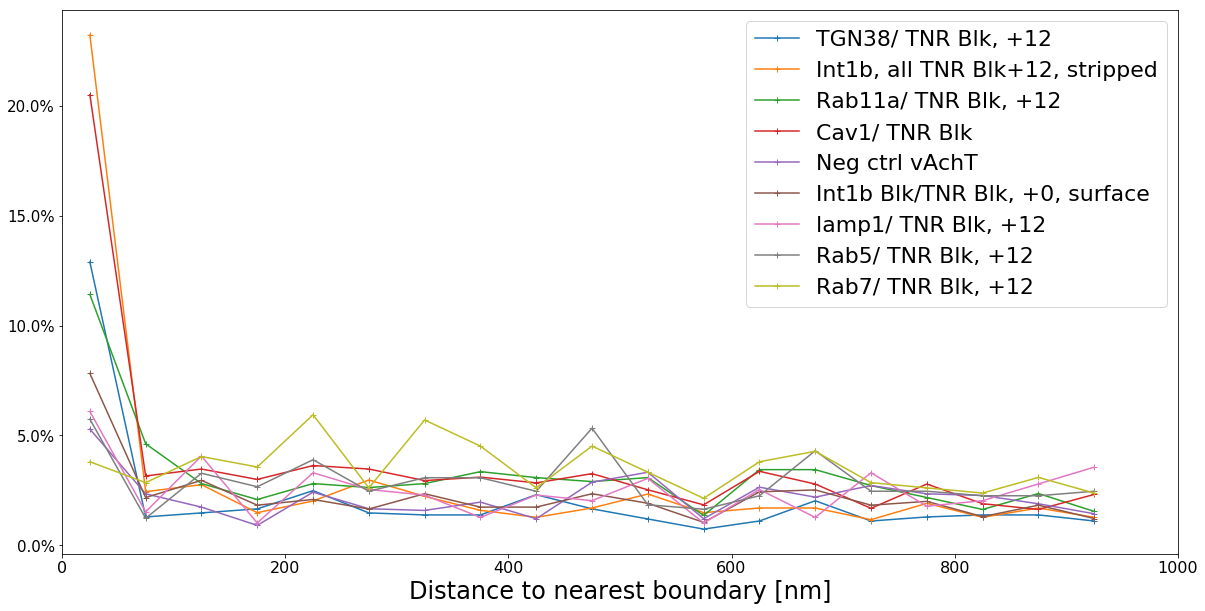

In [28]:
import matplotlib.ticker as ticker
from matplotlib.ticker import PercentFormatter
proteins=[]
fig=plt.figure(figsize=(20,10))
df2=deepcopy(dfspots)
df2=df2[df2["Protein"]!="Pos ctrl 2 secondaries"]

for protein in df2["Protein"].unique():
    df2plot=df2[df2["Protein"]==protein]
    proteins.append(protein)
    p=fig.add_subplot(111)
    data=df2plot["distance to nearest endosome boundary [nms]"]
    y,binEdges=np.histogram(data,bins=np.arange(0,1000,50),
                           weights=np.ones(len(data)) / len(data))
                           #density=True)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    p.plot(bincenters,y,'+-')
    
    
    
    #plt.title(protein+" no spots: "+str(len(df2)))
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    #plt.ylim([0,0.03])
    #scale_y=1/100
    #ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
    #p.yaxis.set_major_formatter(ticks_y)
    plt.xlim([0,1000])
    plt.legend(proteins,fontsize=22)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=15)
    plt.xlabel('Distance to nearest boundary [nm]',fontsize=24)
    

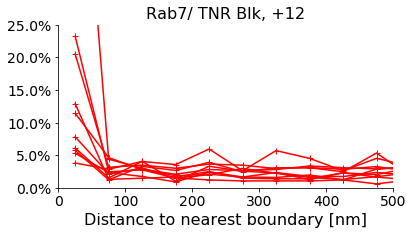

In [60]:
import matplotlib.ticker as ticker
from matplotlib.ticker import PercentFormatter
proteins=[]
df2=deepcopy(dfspots)
#df2=df2[df2["Protein"]!="Pos ctrl 2 secondaries"]
fig=plt.figure(figsize=(6,3))
ax=fig.add_subplot(111)

for protein in df2["Protein"].unique():
    df2plot=df2[df2["Protein"]==protein]
    proteins.append(protein)
    #
    
    
    data=df2plot["distance to nearest endosome boundary [nms]"]
    y,binEdges=np.histogram(data,bins=np.arange(0,1000,50),
                           weights=np.ones(len(data)) / len(data))
                           #density=True)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    ax.plot(bincenters,y,'+-',color='red')
    
    
    
    #plt.title(protein+" no spots: "+str(len(df2)))
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    #plt.ylim([0,0.03])
    #scale_y=1/100
    #ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
    #p.yaxis.set_major_formatter(ticks_y)
    plt.xlim([0,500])
    plt.title(protein,fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Distance to nearest boundary [nm]',fontsize=16)
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    plt.ylim(0,.25)
    

## Plot: histogram for all proteins different axis, with rotated histogram

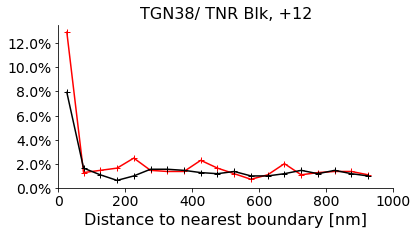

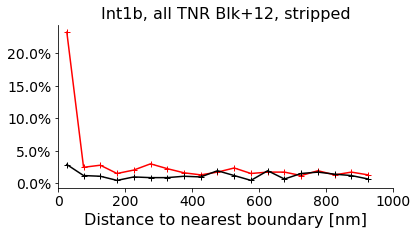

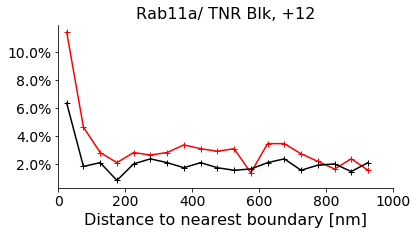

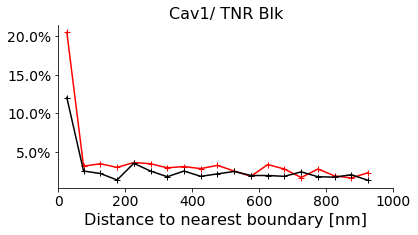

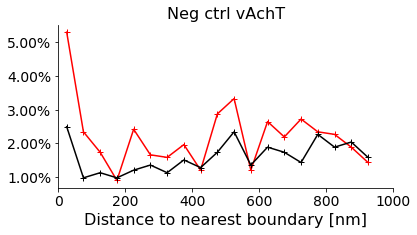

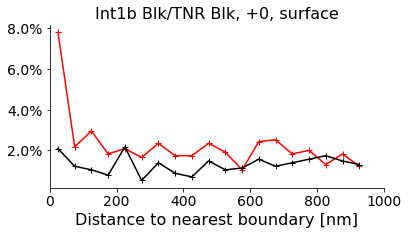

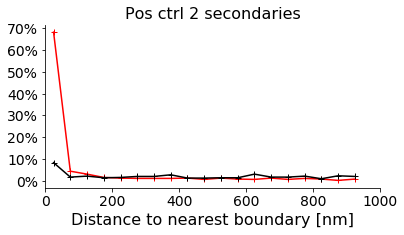

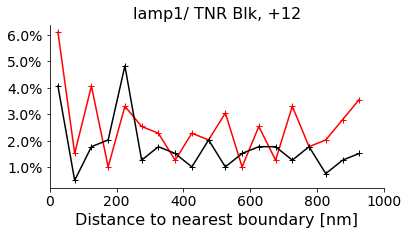

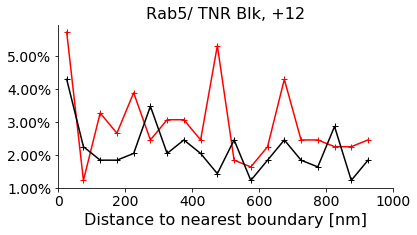

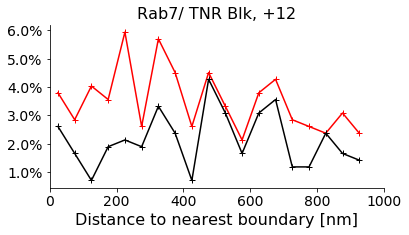

In [47]:
import matplotlib.ticker as ticker
from matplotlib.ticker import PercentFormatter
proteins=[]
df2=deepcopy(dfspots)
#df2=df2[df2["Protein"]!="Pos ctrl 2 secondaries"]

for protein in df2["Protein"].unique():
    df2plot=df2[df2["Protein"]==protein]
    proteins.append(protein)
    fig=plt.figure(figsize=(6,3))
    ax=fig.add_subplot(111)
    
    data=df2plot["distance to nearest endosome boundary [nms]"]
    y,binEdges=np.histogram(data,bins=np.arange(0,1000,50),
                           weights=np.ones(len(data)) / len(data))
                           #density=True)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    ax.plot(bincenters,y,'+-',color='red')
    
    data=df2plot["rotated - distance to nearest endosome boundary [nms]"]
    y,binEdges=np.histogram(data,bins=np.arange(0,1000,50),
                           weights=np.ones(len(data)) / len(data))
                           #density=True)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    ax.plot(bincenters,y,'+-',color='black')
    
    
    
    #plt.title(protein+" no spots: "+str(len(df2)))
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    #plt.ylim([0,0.03])
    #scale_y=1/100
    #ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
    #p.yaxis.set_major_formatter(ticks_y)
    plt.xlim([0,1000])
    plt.title(protein,fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Distance to nearest boundary [nm]',fontsize=16)
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    

In [1]:
import matplotlib.ticker as ticker
from matplotlib.ticker import PercentFormatter
proteins=[]
fig=plt.figure(figsize=(20,10))
df2=deepcopy(dfspots)
df2=df2[df2["Protein"]=="Pos ctrl 2 secondaries"]

for protein in df2["Protein"].unique():
    df2plot=df2[df2["Protein"]==protein]
    proteins.append(protein)
    p=fig.add_subplot(111)
    data=df2plot["distance to nearest endosome boundary [nms]"]
    y,binEdges=np.histogram(data,bins=np.arange(0,1000,50),
                           weights=np.ones(len(data)) / len(data))
                           #density=True)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    p.plot(bincenters,y,'+-')
    
    
    
    #plt.title(protein+" no spots: "+str(len(df2)))
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    #plt.ylim([0,0.03])
    #scale_y=1/100
    #ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
    #p.yaxis.set_major_formatter(ticks_y)
    plt.xlim([0,1000])
    plt.legend(proteins,fontsize=22)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=15)
    plt.xlabel('Distance to nearest boundary [nm]',fontsize=24)
    

NameError: name 'plt' is not defined

(array([-1000.,     0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,
         7000.]), <a list of 9 Text xticklabel objects>)

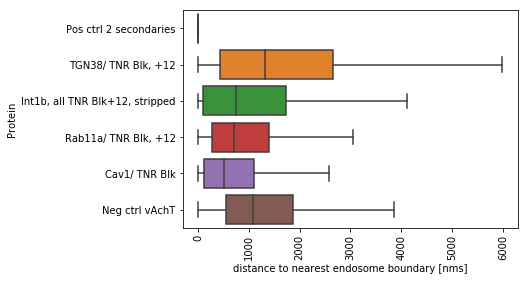

In [225]:
order=["Pos ctrl 2 secondaries",'TGN38/ TNR Blk, +12',
 'Int1b, all TNR Blk+12, stripped',
 'Rab11a/ TNR Blk, +12',
 'Cav1/ TNR Blk','Neg ctrl vAchT']
plt.figure()
sns.boxplot(y="Protein",x="distance to nearest endosome boundary [nms]",data=dfspots,showfliers=False,
              order=order)
plt.xticks(rotation=90)
#plt.xlim([0,5000])

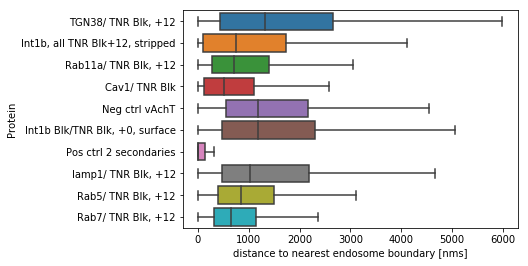

In [53]:
sns.boxplot(y="Protein",x="distance to nearest endosome boundary [nms]",data=dfspots,showfliers=False)
#plt.xlim([0,1000])

## Real versus rotated - min distance in each image, per protein

## Real vs rot - percent under 50nm distance

In [383]:
df_ecm["expname"]=df_ecm["exp condition"]
for i in range(0,len(df_ecm)):
    df_ecm["expname"][i]=df_ecm["exp condition"][i][0:8]

In [476]:
#spots dictionary
exps_under={"proteinl":[],"percentunderl":[],"expname":[]}
              
nanometers=200

for exp in dfspots["expname"].unique():
    dfexp=dfspots[dfspots["expname"]==exp].reset_index()
    for protein in dfexp["Protein"].unique():
        df2plot=dfexp[dfexp["Protein"]==protein]
        exps_under["expname"].append(exp)
        exps_under["percentunderl"].append(np.sum(df2plot["distance to nearest endosome boundary [nms]"]<nanometers)/len(df2plot["distance to nearest endosome boundary [nms]"])*100)
        exps_under["proteinl"].append(protein)
        #exps_under["percentunderl"].append(percent_under*100)

dfexps_under=pd.DataFrame(exps_under)

In [477]:
#dfexps_under=dfexps_under[dfexps_under["proteinl"].str.contains("Int")==False]
dfexps_integrin=dfexps_under[(dfexps_under["proteinl"].str.contains("Rab")==False)&
                            (dfexps_under["proteinl"].str.contains("lamp")==False)&
                            (dfexps_under["proteinl"].str.contains("TGN")==False)&
                            (dfexps_under["proteinl"].str.contains("Cav")==False)]

In [475]:
dfexps_integrin

,proteinl,percentunderl,expname
8,Neg ctrl vAchT,10.030395,20190522_negctrl_tnrstar580_achtatto647
20,Pos ctrl 2 secondaries,86.834734,20190627_positivecontrol_tnr_secondarystar580_...
21,Neg ctrl vAchT,7.614213,20190602_negctrl_tnrstar580_achtatto647_analyse
22,Neg ctrl vAchT,6.382979,20190612_negctrl_tnrstar580_achtatto647_analyse
26,Pos ctrl 2 secondaries,65.686275,20190703_positivecontrol_tnr_secondarystar580_...


In [444]:
result["proteinl"]

3                     Neg ctrl vAchT
9                lamp1/ TNR Blk, +12
6                 Rab5/ TNR Blk, +12
7                 Rab7/ TNR Blk, +12
1     Int1b Blk/TNR Blk, +0, surface
8                TGN38/ TNR Blk, +12
5               Rab11a/ TNR Blk, +12
0                      Cav1/ TNR Blk
2    Int1b, all TNR Blk+12, stripped
4             Pos ctrl 2 secondaries
Name: proteinl, dtype: object

Text(1.0, 50.86834733893557, '*')

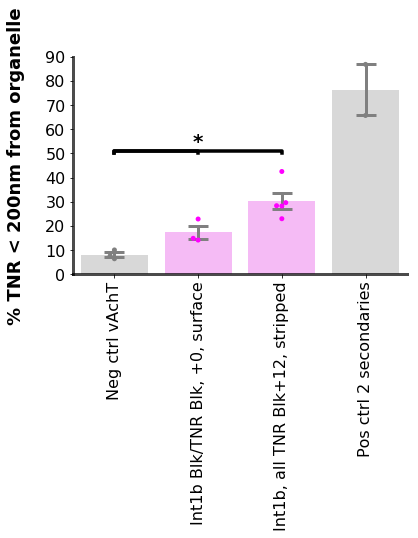

In [483]:
result = dfexps_integrin.groupby(["proteinl"])['percentunderl'].aggregate(np.mean).reset_index().sort_values('percentunderl')
var="percentunderl"
yerrs=[]
for protein in result["proteinl"]:
    yerror=dfexps_integrin[dfexps_integrin["proteinl"]==protein]["percentunderl"].sem()
    yerrs.append(yerror)


palette={"Neg ctrl vAchT":'grey',"Int1b Blk/TNR Blk, +0, surface":'magenta',
        "Int1b, all TNR Blk+12, stripped":'magenta',"Pos ctrl 2 secondaries":'grey'}    
g=sns.barplot(x="proteinl",y="percentunderl",data=dfexps_integrin,palette=palette,order=result['proteinl'],ci=None,alpha=.3)
g=sns.swarmplot(x="proteinl",y="percentunderl",data=dfexps_integrin,palette=palette,order=result['proteinl'])

g.errorbar(x=np.arange(0,len(result)),
             y=list(result["percentunderl"]),
             yerr=yerrs,
             xerr=None,ecolor='grey',fmt='none',capsize=10,linewidth=3,capthick=3)



plt.ylim([0,90])

g.set_ylabel('% TNR < 200nm from organelle',size=18,weight ='bold',labelpad=20)
g.set_xlabel('',color='black',alpha=.7)
plt.xticks(g.get_xticks(),size=16,rotation=90)
plt.yticks(g.get_yticks(),size=16)
g.grid(False)

sns.despine(ax=g,right=True,top=True)
for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(3)
  g.spines[axis].set_color('black')
  g.spines[axis].set_alpha(.7)


x1, x2 = 0,1
y= 50
h=0.01*dfexps_integrin[var].max()
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
#plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col,size=20, weight='bold')

x1, x2 = 0,2
y= 50
h=0.01*dfexps_integrin[var].max()
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col,size=20, weight='bold')




In [ ]:
result = dfexps_under.groupby(["proteinl"])['percentunderl'].aggregate(np.mean).reset_index().sort_values('percentunderl')
var="percentunderl"
yerrs=[]
for protein in result["proteinl"]:
    yerror=dfexps_under[dfexps_under["proteinl"]==protein]["percentunderl"].sem()
    yerrs.append(yerror)


palette={"Neg ctrl vAchT":'grey',"lamp1/ TNR Blk, +12":'magenta',"Rab5/ TNR Blk, +12":'magenta',
        "Rab7/ TNR Blk, +12":'magenta',"TGN38/ TNR Blk, +12":'magenta',"Rab11a/ TNR Blk, +12":'magenta',
        "Cav1/ TNR Blk":'magenta',"Pos ctrl 2 secondaries":'grey'}    
g=sns.barplot(x="proteinl",y="percentunderl",data=dfexps_under,palette=palette,order=result['proteinl'],ci=None,alpha=.3)
g=sns.swarmplot(x="proteinl",y="percentunderl",data=dfexps_under,palette=palette,order=result['proteinl'])

g.errorbar(x=np.arange(0,len(result)),
             y=list(result["percentunderl"]),
             yerr=yerrs,
             xerr=None,ecolor='grey',fmt='none',capsize=10,linewidth=3,capthick=3)



plt.ylim([0,90])

g.set_ylabel('% TNR < 200nm from organelle',size=18,weight ='bold',labelpad=20)
g.set_xlabel('',color='black',alpha=.7)
plt.xticks(g.get_xticks(),size=16,rotation=90)
plt.yticks(g.get_yticks(),size=16)
g.grid(False)

sns.despine(ax=g,right=True,top=True)
for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(3)
  g.spines[axis].set_color('black')
  g.spines[axis].set_alpha(.7)

x1, x2 = 0,4
y= 35
h=0.01*dfexps_under[var].max()
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
#plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col,size=28, weight='bold')

x1, x2 = 0,6
y= 35
h=0.01*dfexps_under[var].max()
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col,size=20, weight='bold')



x1, x2 = 0,5
y= 45
h=0.01*dfexps_under[var].max()
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col,size=20, weight='bold')





In [391]:
dfexps_calc=dfexps_under[dfexps_under["proteinl"]!="Pos ctrl 2 secondaries"]
dfcalc=dfexps_calc[["proteinl","percentunderl"]].copy()

(<matplotlib.axes._subplots.AxesSubplot at 0x13603eac8>,
 <matplotlib.colorbar.ColorbarBase at 0x1362774e0>)

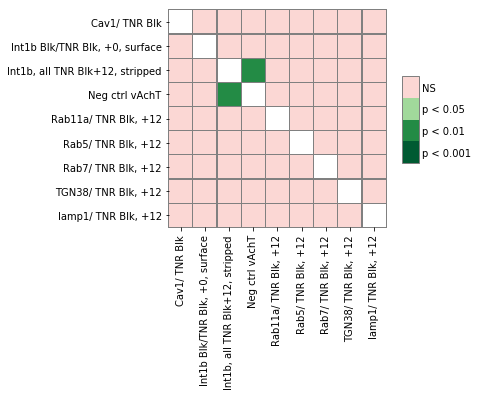

In [392]:

import scikit_posthocs as sp
pc=sp.posthoc_dunn(dfcalc, group_col="proteinl",val_col="percentunderl",p_adjust = 'bonf',)
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
sp.sign_plot(pc, **heatmap_args)

## anova

In [393]:
import scipy.stats as stats
stats.f_oneway(dfexps_under["percentunderl"])

F_onewayResult(statistic=nan, pvalue=nan)

In [222]:
dfexps_under["proteinl"].unique()

array(['TGN38/ TNR Blk, +12', 'Int1b, all TNR Blk+12, stripped',
       'Rab11a/ TNR Blk, +12', 'Cav1/ TNR Blk', 'Neg ctrl vAchT',
       'Int1b Blk/TNR Blk, +0, surface', 'Pos ctrl 2 secondaries',
       'lamp1/ TNR Blk, +12', 'Rab5/ TNR Blk, +12', 'Rab7/ TNR Blk, +12'],
      dtype=object)

In [237]:
neg

array([4.86322188, 2.03045685, 4.96453901])

In [394]:
var="percentunderl"

neg=dfexps_under[dfexps_under["proteinl"]=="Neg ctrl vAchT"][var].dropna().values
tgn=dfexps_under[dfexps_under["proteinl"]=="TGN38/ TNR Blk, +12"][var].dropna().values
intstripped=dfexps_under[dfexps_under["proteinl"]=="Int1b, all TNR Blk+12, stripped"][var].dropna().values
rab=dfexps_under[dfexps_under["proteinl"]=="Rab11a/ TNR Blk, +12"][var].dropna().values
cav=dfexps_under[dfexps_under["proteinl"]=="Cav1/ TNR Blk"][var].dropna().values
intsurface=dfexps_under[dfexps_under["proteinl"]=="Int1b Blk/TNR Blk, +0, surface"][var].dropna().values
#intsurface=dfexps_under[dfexps_under["proteinl"]=="Int1b Blk/TNR Blk, +0, surface"][var].dropna().values

stats.f_oneway(neg, tgn, intstripped,rab,cav,intsurface)

F_onewayResult(statistic=8.585323910975678, pvalue=0.00041296185568426747)

In [455]:
[stat,pval]=stats.ttest_ind(neg, tgn)
print('tgn:'+str(pval*8))
[stat,pval]=stats.ttest_ind(neg, intstripped)
print('intstripped:'+str(pval*8))
[stat,pval]=stats.ttest_ind(neg, rab)
print('rab:'+str(pval*8))
[stat,pval]=stats.ttest_ind(neg, cav)
print('cav:'+str(pval*8))
[stat,pval]=stats.ttest_ind(neg, intsurface)
print('intsurface:'+str(pval*8))

tgn:0.14871234198305308
intstripped:0.018415340482325335
rab:0.0007044052785527676
cav:0.021436611679817492
intsurface:0.290643496217917


## post hoc tukey

In [328]:
import ipywidgets as widgets
from ipywidgets import interact
import scipy.stats as stats
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi
from statsmodels.stats.libqsturng import psturng

#x = dfmeans[dfmeans["condition"].str.contains("Bic")==False]["condition"]
#y = dfmeans[dfmeans["condition"].str.contains("Bic")==False][var]
x=dfexps_calc["proteinl"]
y=dfexps_calc[var]
# DataFrame.
mcDate = multi.MultiComparison(y,x)
Results = mcDate.tukeyhsd()
df = pd.DataFrame(data=Results._results_table.data[1:], columns=Results._results_table.data[0])
res=Results
pvals=psturng(np.abs(res.meandiffs / res.std_pairs),len(res.groupsunique), res.df_total)
df["pvals"]=pvals

df

,group1,group2,meandiff,lower,upper,reject,pvals
0,Cav1/ TNR Blk,"Int1b Blk/TNR Blk, +0, surface",-9.5311,-28.0532,8.9909,False,0.647128
1,Cav1/ TNR Blk,"Int1b, all TNR Blk+12, stripped",8.1359,-8.1322,24.4041,False,0.674366
2,Cav1/ TNR Blk,Neg ctrl vAchT,-15.9343,-34.4564,2.5878,False,0.122681
3,Cav1/ TNR Blk,"Rab11a/ TNR Blk, +12",-3.5880,-20.7361,13.5601,False,0.900000
4,Cav1/ TNR Blk,"Rab5/ TNR Blk, +12",-11.0337,-38.1472,16.0799,False,0.849744
5,Cav1/ TNR Blk,"Rab7/ TNR Blk, +12",-9.6917,-36.8053,17.4219,False,0.900000
6,Cav1/ TNR Blk,"TGN38/ TNR Blk, +12",-5.6200,-24.1421,12.9021,False,0.900000
7,Cav1/ TNR Blk,"lamp1/ TNR Blk, +12",-11.2531,-38.3667,15.8604,False,0.834505
8,"Int1b Blk/TNR Blk, +0, surface","Int1b, all TNR Blk+12, stripped",17.6671,-0.0434,35.3776,False,0.050824
9,"Int1b Blk/TNR Blk, +0, surface",Neg ctrl vAchT,-6.4032,-26.2041,13.3978,False,0.900000


In [20]:
nanometers=50
df_ecm["df_percentunder"]=df_ecm["distances to nearest endosome boundary [nms]"]
df_ecm["rot_df_percentunder"]=df_ecm["rotated - distances to nearest endosome boundary [nms]"]
for i in range(0,len(df_ecm)):
    df_ecm["df_percentunder"][i]=np.sum(
        np.array(df_ecm["distances to nearest endosome boundary [nms]"][i])<nanometers)/len(df_ecm["distances to nearest endosome boundary [nms]"][i])*100
    df_ecm["rot_df_percentunder"][i]=np.sum(
        np.array(df_ecm["rotated - distances to nearest endosome boundary [nms]"][i])<nanometers)/len(df_ecm["rotated - distances to nearest endosome boundary [nms]"][i])*100
    
df_ecm["df_percentunder"]=df_ecm["df_percentunder"].astype(float)
df_ecm["rot_df_percentunder"]=df_ecm["rot_df_percentunder"].astype(float)

## post hoc tueky

In [21]:
df_ecm["real minus rot"]=df_ecm["df_percentunder"]-df_ecm["rot_df_percentunder"]

In [22]:
df_ecm.loc[df_ecm["real minus rot"]<0,"real minus rot"]=0

In [389]:
df2plot=df_ecm[df_ecm["Protein"]!="Pos ctrl 2 secondaries"]
order=['TGN38/ TNR Blk, +12', 'Int1b, all TNR Blk+12, stripped',
       'Rab11a/ TNR Blk, +12', 'Cav1/ TNR Blk', 
       'Int1b Blk/TNR Blk, +0, surface','Neg ctrl vAchT']
plt.figure()
g=sns.boxplot(x="Protein",y="real minus rot",data=df2plot,showfliers=False,order=order)
            #showfliers=False)
for patch in g.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
sns.swarmplot(x="Protein",y="real minus rot",data=df2plot)

        #showfliers=False)
plt.xticks(rotation=90)



ValueError: Could not interpret input 'real minus rot'

<Figure size 432x288 with 0 Axes>

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

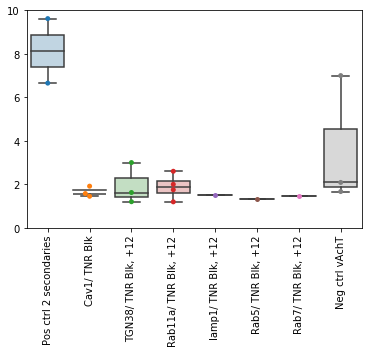

In [110]:
order=['Pos ctrl 2 secondaries','Cav1/ TNR Blk','TGN38/ TNR Blk, +12', 
       'Rab11a/ TNR Blk, +12','lamp1/ TNR Blk, +12','Rab5/ TNR Blk, +12','Rab7/ TNR Blk, +12','Neg ctrl vAchT']
g=sns.boxplot(x=Proteins,y=Percent,order=order)
sns.swarmplot(x=Proteins,y=Percent,order=order)
for patch in g.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
plt.ylim(0,10)
plt.xticks(rotation=90)



(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

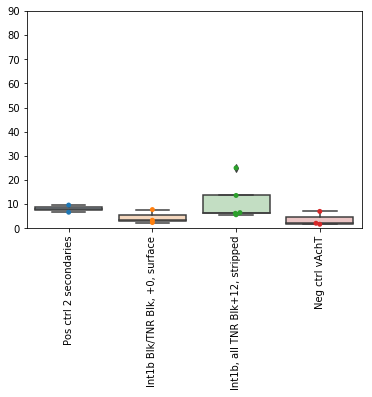

In [43]:
order=['Pos ctrl 2 secondaries', 'Int1b Blk/TNR Blk, +0, surface',
       'Int1b, all TNR Blk+12, stripped','Neg ctrl vAchT']
g=sns.boxplot(x=Proteins,y=Percent,order=order)
sns.swarmplot(x=Proteins,y=Percent,order=order)
for patch in g.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
plt.ylim(0,90)
plt.xticks(rotation=90)




##### combine into a single dataframe with rotated or real as a category

In [65]:
df_ecm_copy=deepcopy(df_ecm)
df_ecm_copy["percent_under"]=df_ecm_copy["df_percentunder"]
df_ecm_copy["Real or rot"]="Real"
df_ecm_copy2=deepcopy(df_ecm)
df_ecm_copy2["percent_under"]=df_ecm_copy["rot_df_percentunder"]
df_ecm_copy2["Real or rot"]="Rotated"
df_merged=df_ecm_copy.append(df_ecm_copy2)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

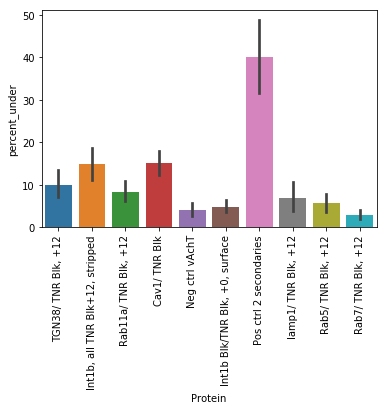

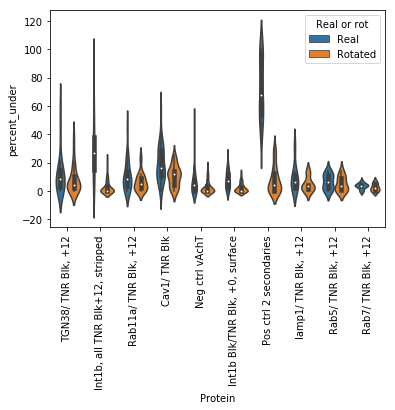

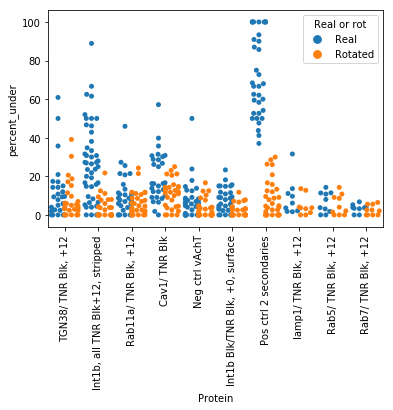

In [66]:
plt.figure()
sns.barplot(x="Protein",y="percent_under",data=df_merged)
            #showfliers=False)
plt.xticks(rotation=90)

plt.figure()
sns.violinplot(x="Protein",y="percent_under",data=df_merged,hue="Real or rot")
plt.xticks(rotation=90)

plt.figure()
sns.swarmplot(x="Protein",y="percent_under",data=df_merged,hue="Real or rot",dodge=True)
plt.xticks(rotation=90)

In [ ]:
#spots dictionary


## Find representative images for each condition

In [ ]:
df2show.columns

In [ ]:
df_originaldata=pd.DataFrame(results)
df_originaldata['Protein']='None'
df_originaldata.loc[(df_originaldata['exp condition'].str.contains('nt'))&(df_originaldata['exp condition'].str.contains('12')), 'Protein'] = 'Int1b, all TNR Blk+12, stripped'
df_originaldata.loc[(df_originaldata['exp condition'].str.contains('nt'))&(df_originaldata['exp condition'].str.contains('surface')), 'Protein'] = 'Int1b Blk/TNR Blk, +0, surface'
df_originaldata.loc[df_originaldata['exp condition'].str.contains('tgn'), 'Protein'] = 'TGN38/ TNR Blk, +12'
df_originaldata.loc[df_originaldata['exp condition'].str.contains('rab'), 'Protein'] = 'Rab11a/ TNR Blk, +12'
df_originaldata.loc[df_originaldata['exp condition'].str.contains('cav'), 'Protein'] = 'Cav1/ TNR Blk'

In [ ]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')


protein='TGN38/ TNR Blk, +12'

df2show=df_originaldata[df_originaldata["Protein"]==protein]

for image in range(0,len(df2show)):
    ecm_channel_no=df_originaldata["ecmchannelno"][image]
    endosome_channel_no=df_originaldata["endosomechannelno"][image]
    ecm_image_name=df_originaldata["filename"][image]+"0_ch"+str(ecm_channel_no-1)+"_t0.tif"
    endosome_image_name=df_originaldata["filename"][image]+"0_ch"+str(endosome_channel_no-1)+"_t0.tif"
    ecm_image=pims.open(ecm_image_name)[0]
    endosome_image=pims.open(endosome_image_name)[0]
    fig=plt.figure(figsize=(9,3))
    fig.add_subplot(131)
    plt.imshow(ecm_image,cmap='viridis',vmin=0.2*np.mean(ecm_image),vmax=0.8*np.max(ecm_image))
    plt.axis(show=False)
    plt.title('TNR', fontsize=14)
    fig.add_subplot(132)
    plt.imshow(endosome_image,cmap='viridis',vmin=0.2*np.mean(endosome_image),vmax=0.8*np.max(endosome_image))
    plt.axis(show=False)
    plt.title(protein, fontsize=14)
    plt.tight_layout()

In [ ]:
results.keys()

In [67]:
df_ecm.columns

Index(['filename', 'exp condition', 'distances to nearest endosome boundary',
       'distances to nearest endosome boundary [nms]',
       'min distance to nearest endosome boundary for whole image',
       'min distance to nearest endosome boundary for whole image [nms]',
       'rotated - distances to nearest endosome boundary',
       'rotated - distances to nearest endosome boundary [nms]',
       'rotated - min distance to nearest endosome boundary for whole image',
       'rotated - min distance to nearest endosome boundary for whole image [nms]',
       'Protein', 'df_percentunder', 'rot_df_percentunder', 'real minus rot',
       'expname'],
      dtype='object')

In [83]:
results["corrcoeff"]=[]
results["corrcoeff_rotated"]=[]

for i in range(0,len(results["filename"])):
    ecm_channel_no=results["ecmchannelno"][i]
    endosome_channel_no=results["endosomechannelno"][i]

    ecm_image_name=results["filename"][i]+"0_ch"+str(ecm_channel_no-1)+"_t0.tif"
    endosome_image_name=results["filename"][i]+"0_ch"+str(endosome_channel_no-1)+"_t0.tif"

    ecm_image=pims.open(ecm_image_name)[0]
    endosome_image=pims.open(endosome_image_name)[0]
    
    results["corrcoeff"].append(corr2(ecm_image,endosome_image))
    results["corrcoeff_rotated"].append(corr2(np.rot90(ecm_image),endosome_image))



ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ ser

TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages:

ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ ser

ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ ser

TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages:

ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ ser

TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


In [70]:
def mean2(x):
    y = np.sum(x) / np.size(x);
    return y

def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r

In [86]:
for key in results.keys():
    print(key)
    print(len(results[key]))

filename
278
exp condition
278
ecmchannelno
278
endosomechannelno
278
Manual ECM spots mask
0
Manual endosome spots mask
0
corrcoeff
278
corrcoeff_rotated
278


In [87]:
del(results["Manual ECM spots mask"])
del(results["Manual endosome spots mask"])
newdf=pd.DataFrame(results)


In [93]:
newdf['Protein']='None'
newdf.loc[(newdf['exp condition'].str.contains('nt'))&(newdf['exp condition'].str.contains('12')), 'Protein'] = 'Int1b, all TNR Blk+12, stripped'
newdf.loc[(newdf['exp condition'].str.contains('nt'))&(newdf['exp condition'].str.contains('surface')), 'Protein'] = 'Int1b Blk/TNR Blk, +0, surface'
newdf.loc[newdf['exp condition'].str.contains('tgn'), 'Protein'] = 'TGN38/ TNR Blk, +12'
newdf.loc[newdf['exp condition'].str.contains('rab11'), 'Protein'] = 'Rab11a/ TNR Blk, +12'
newdf.loc[newdf['exp condition'].str.contains('cav'), 'Protein'] = 'Cav1/ TNR Blk'
newdf.loc[newdf['exp condition'].str.contains('negctrl'), 'Protein'] = 'Neg ctrl vAchT'
newdf.loc[newdf['exp condition'].str.contains('positivecontrol'), 'Protein'] = 'Pos ctrl 2 secondaries'
newdf.loc[newdf['exp condition'].str.contains('rab7'), 'Protein'] = 'Rab7/ TNR Blk, +12'
newdf.loc[newdf['exp condition'].str.contains('rab5'), 'Protein'] = 'Rab5/ TNR Blk, +12'
newdf.loc[newdf['exp condition'].str.contains('lamp'), 'Protein'] = 'lamp1/ TNR Blk, +12'

In [102]:
newdf["corrcoeff"].sort()["Protein"]

AttributeError: 'Series' object has no attribute 'sort'

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

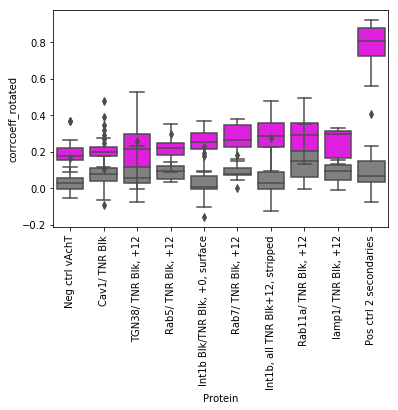

In [109]:
result = newdf.groupby(["Protein"])['corrcoeff'].aggregate(np.median).reset_index().sort_values('corrcoeff')

sns.boxplot(x="Protein",y="corrcoeff",data=newdf,color='magenta',order=result['Protein'])
sns.boxplot(x="Protein",y="corrcoeff_rotated",data=newdf,color='grey',order=result['Protein'])


plt.xticks(rotation=90)